# Read Schema Diagrams

DataJoint diagrams visualize schema structure as directed acyclic graphs (DAGs). This guide teaches you to:

- Interpret line styles and their semantic meaning
- Recognize dimensions (underlined vs non-underlined tables)
- Use diagram operations to explore large schemas
- Compare DataJoint notation to traditional ER diagrams

In [1]:
import datajoint as dj
import os

# Configure from environment variables (for testing with different backends)
if os.getenv('DJ_HOST'):
    dj.config['database.host'] = os.getenv('DJ_HOST')
if os.getenv('DJ_PORT'):
    dj.config['database.port'] = int(os.getenv('DJ_PORT'))
if os.getenv('DJ_USER'):
    dj.config['database.user'] = os.getenv('DJ_USER')
if os.getenv('DJ_PASS'):
    dj.config['database.password'] = os.getenv('DJ_PASS')

schema = dj.Schema('howto_diagrams')
schema.drop(prompt=False)
schema = dj.Schema('howto_diagrams')

[2026-01-17 00:48:21,175][INFO]: DataJoint 2.0.0a22 connected to root@127.0.0.1:3306


## Quick Reference

| Line Style | Relationship | Child's Primary Key |
|------------|--------------|---------------------|
| **Thick Solid** ━━━ | Extension | Parent PK only (one-to-one) |
| **Thin Solid** ─── | Containment | Parent PK + own fields (one-to-many) |
| **Dashed** ┄┄┄ | Reference | Own independent PK (one-to-many) |

**Key principle:** Solid lines mean the parent's identity becomes part of the child's identity. Dashed lines mean the child maintains independent identity.

## Thick Solid Line: Extension (One-to-One)

The foreign key **is** the entire primary key. The child extends the parent.

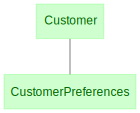

In [2]:
@schema
class Customer(dj.Manual):
    definition = """
    customer_id : int64
    ---
    name : varchar(60)
    """

@schema
class CustomerPreferences(dj.Manual):
    definition = """
    -> Customer               # FK is entire PK
    ---
    theme : varchar(20)
    notifications : bool
    """

dj.Diagram(Customer) + dj.Diagram(CustomerPreferences)

**Equivalent ER Diagram:**

<img src="/images/er-one-to-one.svg" alt="ER One-to-One" width="280">

**DataJoint vs ER:** The thick solid line immediately shows this is one-to-one. In ER notation, you must read the crow's foot symbols (`||--o|`).

**Note:** `CustomerPreferences` is **not underlined** — it exists in the Customer dimension space.

## Thin Solid Line: Containment (One-to-Many)

The foreign key is **part of** the primary key, with additional fields.

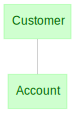

In [3]:
@schema
class Account(dj.Manual):
    definition = """
    -> Customer               # Part of PK
    account_num : int32      # Additional PK field
    ---
    balance : decimal(10,2)
    """

dj.Diagram(Customer) + dj.Diagram(Account)

**Equivalent ER Diagram:**

<img src="/images/er-one-to-many.svg" alt="ER One-to-Many" width="280">

**DataJoint vs ER:** The thin solid line shows containment — accounts belong to customers. In ER, you see `||--o{` (one-to-many).

**Note:** `Account` is **underlined** — it introduces the Account dimension.

## Dashed Line: Reference (One-to-Many)

The foreign key is a **secondary attribute** (below the `---` line).

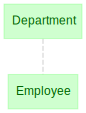

In [4]:
@schema
class Department(dj.Manual):
    definition = """
    dept_id : int32
    ---
    dept_name : varchar(60)
    """

@schema
class Employee(dj.Manual):
    definition = """
    employee_id : int64      # Own independent PK
    ---
    -> Department             # Secondary attribute
    employee_name : varchar(60)
    """

dj.Diagram(Department) + dj.Diagram(Employee)

**Equivalent ER Diagram:**

<img src="/images/er-reference.svg" alt="ER Reference" width="280">

**DataJoint vs ER:** Both show one-to-many, but DataJoint's dashed line tells you immediately that Employee has independent identity. In ER, you must examine whether the FK is part of the PK.

**Note:** Both tables are **underlined** — each introduces its own dimension.

## Dimensions and Underlined Names

A **dimension** is a new entity type introduced by a table that defines new primary key attributes. Each underlined table introduces exactly **one** dimension—even if it has multiple new PK attributes, together they identify one new entity type.

| Visual | Meaning |
|--------|--------|
| **Underlined** | Introduces a new dimension (new entity type) |
| Not underlined | Exists in the space defined by dimensions from referenced tables |

**Key rules:**
- Computed tables **never** introduce dimensions (always non-underlined)
- Part tables **can** introduce dimensions (may be underlined)

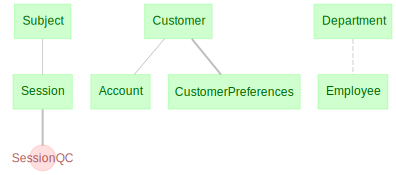

In [5]:
@schema
class Subject(dj.Manual):
    definition = """
    subject_id : varchar(16)  # NEW dimension
    ---
    species : varchar(50)
    """

@schema
class Session(dj.Manual):
    definition = """
    -> Subject                # Inherits subject_id
    session_idx : int32      # NEW dimension
    ---
    session_date : date
    """

@schema 
class SessionQC(dj.Computed):
    definition = """
    -> Session                # Inherits both, adds nothing
    ---
    passed : bool
    """
    def make(self, key):
        self.insert1({**key, 'passed': True})

dj.Diagram(schema)

In this diagram:
- `Subject` is **underlined** — introduces the Subject dimension
- `Session` is **underlined** — introduces the Session dimension (within each Subject)
- `SessionQC` is **not underlined** — exists in the Session dimension space, adds no new dimension

**Why this matters:** Dimensions determine [attribute lineage](../explanation/entity-integrity.md#dimensions-and-attribute-lineage). Primary key attributes trace back to the dimension where they originated, enabling [semantic matching](../reference/specs/semantic-matching.md) for safe joins.

## Many-to-Many: Converging Lines

Many-to-many relationships appear as tables with multiple solid lines converging.

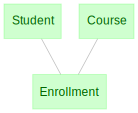

In [6]:
@schema
class Student(dj.Manual):
    definition = """
    student_id : int64
    ---
    name : varchar(60)
    """

@schema
class Course(dj.Manual):
    definition = """
    course_code : char(8)
    ---
    title : varchar(100)
    """

@schema
class Enrollment(dj.Manual):
    definition = """
    -> Student
    -> Course
    ---
    grade : enum('A','B','C','D','F')
    """

dj.Diagram(Student) + dj.Diagram(Course) + dj.Diagram(Enrollment)

**Equivalent ER Diagram:**

<img src="/images/er-many-to-many.svg" alt="ER Many-to-Many" width="400">

**DataJoint vs ER:** Both show the association table pattern. DataJoint's converging solid lines immediately indicate the composite primary key.

**Note:** `Enrollment` is **not underlined** — it exists in the space defined by Student × Course dimensions.

## Orange Dots: Renamed Foreign Keys

When referencing the same table multiple times, use `.proj()` to rename. **Orange dots** indicate renamed FKs.

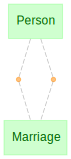

In [7]:
@schema
class Person(dj.Manual):
    definition = """
    person_id : int64
    ---
    name : varchar(60)
    """

@schema
class Marriage(dj.Manual):
    definition = """
    marriage_id : int64
    ---
    -> Person.proj(spouse1='person_id')
    -> Person.proj(spouse2='person_id')
    marriage_date : date
    """

dj.Diagram(Person) + dj.Diagram(Marriage)

The orange dots between `Person` and `Marriage` indicate that projections renamed the foreign key attributes (`spouse1` and `spouse2` both reference `person_id`).

**Tip:** In Jupyter, hover over orange dots to see the projection expression.

## Diagram Operations

Filter and combine diagrams to explore large schemas:

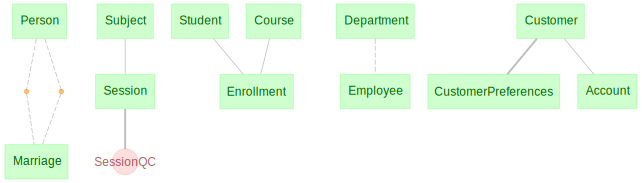

In [8]:
# Entire schema
dj.Diagram(schema)

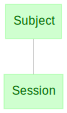

In [9]:
# Session and 1 level upstream (dependencies)
dj.Diagram(Session) - 1

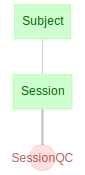

In [10]:
# Subject and 2 levels downstream (dependents)
dj.Diagram(Subject) + 2

**Operation Reference:**

| Operation | Meaning |
|-----------|--------|
| `dj.Diagram(schema)` | Entire schema |
| `dj.Diagram(Table) - N` | Table + N levels upstream |
| `dj.Diagram(Table) + N` | Table + N levels downstream |
| `D1 + D2` | Union of two diagrams |
| `D1 * D2` | Intersection (common nodes) |

**Finding paths:** Use intersection to find connection paths:
```python
(dj.Diagram(upstream) + 100) * (dj.Diagram(downstream) - 100)
```

## What Diagrams Don't Show

Diagrams do **NOT** show these FK modifiers:

| Modifier | Effect | Must Check Definition |
|----------|--------|----------------------|
| `[nullable]` | Optional reference | `-> [nullable] Parent` |
| `[unique]` | One-to-one on secondary FK | `-> [unique] Parent` |

A dashed line could be any of:
- Required one-to-many (default)
- Optional one-to-many (`[nullable]`)
- Required one-to-one (`[unique]`)
- Optional one-to-one (`[nullable, unique]`)

**Always check the table definition** to see modifiers.

## DataJoint vs Traditional ER Notation

| Feature | Chen's ER | Crow's Foot | DataJoint |
|---------|-----------|-------------|----------|
| Cardinality | Numbers | Line symbols | **Line style** |
| Direction | None | None | **Top-to-bottom** |
| Cycles | Allowed | Allowed | **Not allowed** |
| PK cascade | Not shown | Not shown | **Solid lines** |
| Identity sharing | Not indicated | Not indicated | **Thick solid** |
| New dimensions | Not indicated | Not indicated | **Underlined** |

**Why DataJoint differs:**

1. **DAG structure** — No cycles means schemas read as workflows (top-to-bottom)
2. **Line semantics** — Immediately reveals relationship type
3. **Executable** — Diagram is generated from schema, cannot drift out of sync

## Summary

| Visual | Meaning |
|--------|--------|
| **Thick solid** | One-to-one extension |
| **Thin solid** | One-to-many containment |
| **Dashed** | Reference (independent identity) |
| **Underlined** | Introduces new dimension |
| **Orange dots** | Renamed FK via `.proj()` |
| **Colors** | Green=Manual, Gray=Lookup, Red=Computed, Blue=Imported |

## Related

- [Entity Integrity: Dimensions](../explanation/entity-integrity.md#schema-dimensions)
- [Semantic Matching](../reference/specs/semantic-matching.md)
- [Schema Design Tutorial](../tutorials/basics/02-schema-design.ipynb)

In [11]:
schema.drop(prompt=False)